In [331]:
import time

import numpy as np
from numba import njit, jit, objmode
import matplotlib.pyplot as plt

from fmm import Fmm
from fmm.backend.numba import *
from fmm.kernel import *

import adaptoctree.morton as morton

In [332]:
# Numba Threading Layer Configuration

## (Intel CPUs Only) Sets lifetime of OpenMP threads to 0ms
## As computation contains large serial (Python) components
! export KMP_BLOCKTIME=0

## Limit number of threads created by BLAS/LAPACK functions
## Called by Numpy
! export OMP_NUM_THREADS=1

## Define 'places' at which threads are assigned
! export OMP_PLACES=cores

## Makes thread assignment go succesively through available
## places. In our case, through each core.
! export OMP_PROC_BIND=close

## Select OpenMP as threading layer for Numba, the uniformity
## of FMM operators makes it preferable to TBB
! export NUMBA_THREADING_LAYER='omp'

In [334]:
# ! fmm generate-test-data -c test_config
# ! fmm compute-operators -c test_config

Generating sphere sources & targets
Computing operators
Computing octree
Computing Inner Surface of Order 6
Computing Outer Surface of Order 6
Computing Inverse of Check To Equivalent Gram Matrix
Computing M2M & L2L Operators
Computed (1/8) M2M/L2L operators
Computed (2/8) M2M/L2L operators
Computed (3/8) M2M/L2L operators
Computed (4/8) M2M/L2L operators
Computed (5/8) M2M/L2L operators
Computed (6/8) M2M/L2L operators
Computed (7/8) M2M/L2L operators
Computed (8/8) M2M/L2L operators
Computed operators for (1/5) M2L Levels
Computed operators for (2/5) M2L Levels
Computed operators for (3/5) M2L Levels
Computed operators for (4/5) M2L Levels
Computed operators for (5/5) M2L Levels
Total time elapsed 0 minutes and 9 seconds


In [335]:
e = Fmm('test_config', verbose=True)

In [336]:
e.run()

P2M: 0.2228701114654541
M2M: 0.015735864639282227
L2L: 0.01628422737121582
M2L: 3.56333589553833
L2T: 0.2642252445220947
M2T: 1.1644134521484375
S2L: 0.24747323989868164
P2P: 0.4722015857696533


In [337]:
e.clear()
e.run()

P2M: 0.21278047561645508
M2M: 0.014383316040039062
L2L: 0.01630091667175293
M2L: 3.5173656940460205
L2T: 0.2565889358520508
M2T: 1.1842637062072754
S2L: 0.23316001892089844
P2P: 0.4870312213897705


In [346]:
cpu_times = {}

def jit_timer(f):
    """Measure cpu time, i.e. excluding boxing/unboxing time"""
    jf = njit(f)
    @njit
    def wrapper(*args):
        with objmode(start='float64'):
            start = time.time()
        g = jf(*args)
        with objmode():
            end = time.time()
            run_time = end - start
            if f.__name__ in cpu_times:
                cpu_times[f.__name__] += [run_time]
            else:
                cpu_times[f.__name__] = [run_time]
        return g
    return wrapper

def jit_timer_parallel(f):
    """Measure cpu time, i.e. excluding boxing/unboxing time"""
    jf = njit(f, parallel=True)
    @njit
    def wrapper(*args):
        with objmode(start='float64'):
            start = time.time()
        g = jf(*args)
        with objmode():
            end = time.time()
            run_time = end - start
            if f.__name__ in cpu_times:
                cpu_times[f.__name__] += [run_time]
            else:
                cpu_times[f.__name__] = [run_time]
        return g
    return wrapper

In [347]:
@jit_timer_parallel
def m2m(
        keys,
        multipole_expansions,
        m2m,
        key_to_index,
        nequivalent_points,
    ):

    nkeys = len(keys)
    for i in numba.prange(nkeys):
        child = keys[i]
        parent = morton.find_parent(child)

        # Compute operator index
        operator_idx = child == morton.find_siblings(child)

        # Get parent and child expansion indices
        child_idx = key_to_index[child]
        child_lidx = child_idx*nequivalent_points
        child_ridx = child_lidx+nequivalent_points
        child_equivalent_density = multipole_expansions[child_lidx:child_ridx]

        parent_idx = key_to_index[parent]
        parent_lidx = parent_idx*nequivalent_points
        parent_ridx = parent_lidx+nequivalent_points
        
        # Add child contribution to parent multipole expansion
        multipole_expansions[parent_lidx:parent_ridx] += m2m[operator_idx][0] @ child_equivalent_density
#         m2m[operator_idx][0] @ child_equivalent_density

@jit_timer_parallel
def l2l(
    keys,
    local_expansions,
    l2l,
    key_to_index,
    nequivalent_points
):
    nkeys = len(keys)
    for i in numba.prange(nkeys):
        child = keys[i]
        parent = morton.find_parent(child)

        # Compute operator index
        operator_idx = child == morton.find_siblings(child)

        parent_idx = key_to_index[parent]
        parent_lidx = parent_idx*nequivalent_points
        parent_ridx = parent_lidx+nequivalent_points
        parent_equivalent_density = local_expansions[parent_lidx:parent_ridx]

        # Compute expansion index
        child_idx = key_to_index[child]
        child_lidx = child_idx*nequivalent_points
        child_ridx = child_lidx+nequivalent_points

        # Compute contribution to local expansion of child from parent
        local_expansions[child_lidx:child_ridx] += l2l[operator_idx][0] @ parent_equivalent_density
#         l2l[operator_idx][0] @ parent_equivalent_density


@jit_timer_parallel
def m2l(
        keys,
        v_lists,
        u,
        s,
        vt,
        dc2e_inv_a,
        dc2e_inv_b,
        multipole_expansions,
        local_expansions,
        nequivalent_points,
        key_to_index,
        hash_to_index,
        scale
    ):
    nkeys = len(keys)

    for i in numba.prange(nkeys):
        key = keys[i]

        # Pick out the v list
        v_list = v_lists[key_to_index[key]]

        # Filter v list
        v_list = v_list[v_list != -1]
        v_list = v_list[v_list != 0]

        
        nv_list = len(v_list)

        # Indices of local expansion
        l_lidx = key_to_index[key]*nequivalent_points
        l_ridx = l_lidx+nequivalent_points

        for j in range(nv_list):

            source = v_list[j]

            # Locd correct components of compressed M2L matrix
            transfer_vector = morton.find_transfer_vector(key, source)
            v_idx = hash_to_index[transfer_vector]
            v_lidx = v_idx*nequivalent_points
            v_ridx = v_lidx+nequivalent_points
            vt_sub = np.copy(vt[:, v_lidx:v_ridx])

            # Indices of multipole expansion
            m_lidx = key_to_index[source]*nequivalent_points
            m_ridx = m_lidx+nequivalent_points

            local_expansions[l_lidx:l_ridx] += scale*(
                dc2e_inv_a @ (
                    dc2e_inv_b @ (
                        u @ (s @ (vt_sub @ multipole_expansions[m_lidx:m_ridx]))
                    )
                )
            )
            

# @numba.njit(cache=True, parallel=True)
@jit_timer_parallel
def prepare_p2m_data(
        leaves,
        nleaves,
        sources,
        source_densities,
        source_index_pointer,
        key_to_leaf_index,
        x0,
        r0,
        alpha_outer,
        check_surface,
        ncheck_points,
        p2p_function,
        scale_function,
        dtype,
    ):
    scales = np.zeros(shape=nleaves, dtype=dtype)
    check_potentials = np.zeros(shape=(nleaves*ncheck_points), dtype=dtype)

    for thread_idx in numba.prange(nleaves):

        leaf = leaves[thread_idx]

        # Lookup leaf sources, and leaf source densities
        leaf_idx = key_to_leaf_index[leaf]
        leaf_sources = sources[source_index_pointer[leaf_idx]:source_index_pointer[leaf_idx+1]]
        leaf_source_densities = source_densities[source_index_pointer[leaf_idx]:source_index_pointer[leaf_idx+1]]

        # Compute center of leaf box in cartesian coordinates
        leaf_center = morton.find_physical_center_from_key(
            key=leaf, x0=x0, r0=r0
        )

        leaf_level = morton.find_level(leaf)

        upward_check_surface = surface.scale_surface(
            surf=check_surface,
            radius=r0,
            level=leaf_level,
            center=leaf_center,
            alpha=alpha_outer,
        )

        check_potential = p2p_function(
            targets=upward_check_surface,
            sources=leaf_sources,
            source_densities=leaf_source_densities,
        )

        lidx = thread_idx*ncheck_points
        ridx = lidx+ncheck_points
        check_potentials[lidx:ridx] += check_potential
        scales[thread_idx] += scale_function(leaf_level)

    return scales, check_potentials


@jit_timer_parallel
def p2m_core(
        leaves,
        nleaves,
        key_to_index,
        nequivalent_points,
        ncheck_points,
        uc2e_inv_a,
        uc2e_inv_b,
        scales,
        multipole_expansions,
        check_potentials
    ):
    for i in numba.prange(nleaves):

        scale = scales[i]

        check_lidx = i*ncheck_points
        check_ridx = check_lidx+ncheck_points
        check_potential = check_potentials[check_lidx:check_ridx]

        leaf = leaves[i]
        lidx = key_to_index[leaf]*nequivalent_points
        ridx = lidx+nequivalent_points

        multipole_expansions[lidx:ridx] += scale*(uc2e_inv_a @ (uc2e_inv_b @ check_potential))
        

@numba.njit(cache=True)
def p2m(
        leaves,
        nleaves,
        key_to_index,
        key_to_leaf_index,
        sources,
        source_densities,
        source_index_pointer,
        multipole_expansions,
        nequivalent_points,
        x0,
        r0,
        alpha_outer,
        check_surface,
        ncheck_points,
        uc2e_inv_a,
        uc2e_inv_b,
        p2p_function,
        scale_function,
        dtype
    ):

    scales, check_potentials = prepare_p2m_data(
        leaves=leaves,
        nleaves=nleaves,
        sources=sources,
        source_densities=source_densities,
        source_index_pointer=source_index_pointer,
        key_to_leaf_index=key_to_leaf_index,
        x0=x0,
        r0=r0,
        alpha_outer=alpha_outer,
        check_surface=check_surface,
        ncheck_points=ncheck_points,
        p2p_function=p2p_function,
        scale_function=scale_function,
        dtype=dtype
    )

    p2m_core(
        leaves=leaves,
        nleaves=nleaves,
        key_to_index=key_to_index,
        nequivalent_points=nequivalent_points,
        ncheck_points=ncheck_points,
        uc2e_inv_a=uc2e_inv_a,
        uc2e_inv_b=uc2e_inv_b,
        scales=scales,
        multipole_expansions=multipole_expansions,
        check_potentials=check_potentials
    )
    

@jit_timer_parallel
def s2l(
        leaves,
        nleaves,
        sources,
        source_densities,
        source_index_pointer,
        key_to_index,
        key_to_leaf_index,
        x_lists,
        local_expansions,
        x0,
        r0,
        alpha_inner,
        check_surface,
        nequivalent_points,
        dc2e_inv_a,
        dc2e_inv_b,
        scale_function,
        p2p_function,
        dtype
    ):

    nleaves = len(leaves)

    for i in numba.prange(nleaves):

        # Pick out leaf
        leaf = leaves[i]

        # Calculate downward check surface
        level = morton.find_level(leaf)
        scale = dtype(scale_function(level))
        center = morton.find_physical_center_from_key(leaf, x0, r0)

        downward_check_surface = surface.scale_surface(
            surf=check_surface,
            radius=r0,
            level=level,
            center=center,
            alpha=alpha_inner
        )

        # Pick out X list
        key_idx = key_to_index[leaf]
        key_lidx = key_idx*nequivalent_points
        key_ridx = key_lidx+nequivalent_points

        x_list = x_lists[key_idx]
        x_list = x_list[x_list != -1]

        # Apply S2L operator over X list
        for source in x_list:

            source_index = key_to_leaf_index[source]
            coordinates = sources[source_index_pointer[source_index]:source_index_pointer[source_index+1]]
            densities = source_densities[source_index_pointer[source_index]:source_index_pointer[source_index+1]]

            downward_check_potential = p2p_function(
                sources=coordinates,
                targets=downward_check_surface,
                source_densities=densities
            )

            local_expansions[key_lidx:key_ridx] += scale*(dc2e_inv_a @ (dc2e_inv_b @ downward_check_potential))


@jit_timer_parallel
def m2t(
        leaves,
        nleaves,
        w_lists,
        targets,
        target_index_pointer,
        key_to_index,
        key_to_leaf_index,
        target_potentials,
        multipole_expansions,
        x0,
        r0,
        alpha_inner,
        equivalent_surface,
        nequivalent_points,
        p2p_function,
        gradient_function
    ):
    for i in numba.prange(nleaves):
        target_key = leaves[i]
        global_idx = key_to_index[target_key]
        leaf_idx = key_to_leaf_index[target_key]
        w_list = w_lists[global_idx]
        w_list = w_list[w_list != -1]

        # Coordinates of targets within leaf node
        target_coordinates = targets[
            target_index_pointer[leaf_idx]:target_index_pointer[leaf_idx+1]
        ]

        for source in w_list:
            source_idx = key_to_index[source]
            source_lidx = source_idx*nequivalent_points
            source_ridx = source_lidx+nequivalent_points

            source_level = morton.find_level(source)
            source_center = morton.find_physical_center_from_key(source, x0, r0)

            upward_equivalent_surface = surface.scale_surface(
                surf=equivalent_surface,
                radius=r0,
                level=source_level,
                center=source_center,
                alpha=alpha_inner
            )

            target_idx = key_to_leaf_index[target_key]

            target_potentials[target_index_pointer[target_idx]:target_index_pointer[target_idx+1], 0] += p2p_function(
                sources=upward_equivalent_surface,
                targets=target_coordinates,
                source_densities=multipole_expansions[source_lidx:source_ridx]
            )

            target_potentials[target_index_pointer[target_idx]:target_index_pointer[target_idx+1], 1:] += gradient_function(
                sources=upward_equivalent_surface,
                targets=target_coordinates,
                source_densities=multipole_expansions[source_lidx:source_ridx]
            )


@jit_timer
def prepare_l2t_data(
        leaves,
        nleaves,
        targets,
        target_index_pointer,
        equivalent_surface,
        nequivalent_points,
        x0,
        r0,
        alpha_outer,
        key_to_index,
        key_to_leaf_index,
        local_expansions,
        dtype,
    ):

    local_sources = np.zeros((nequivalent_points*nleaves, 3), dtype=dtype)
    local_source_densities = np.zeros((nequivalent_points*nleaves), dtype=dtype)
    local_targets = np.zeros((nequivalent_points*nleaves, 3), dtype=dtype)
    local_source_index_pointer = np.zeros(nleaves+1, np.int64)
    local_target_index_pointer = np.zeros(nleaves+1, np.int64)

    source_ptr = 0
    target_ptr = 0
    local_source_index_pointer[0] = source_ptr
    local_target_index_pointer[0] = target_ptr

    for i in range(nleaves):
        target = leaves[i]
        level = morton.find_level(target)
        center = morton.find_physical_center_from_key(target, x0, r0)
        target_leaf_index = key_to_leaf_index[target]

        targets_at_node = targets[
            target_index_pointer[target_leaf_index]:target_index_pointer[target_leaf_index+1]
        ]

        sources_at_node = surface.scale_surface(
            equivalent_surface,
            r0,
            level,
            center,
            alpha_outer
        )

        source_idx = key_to_index[target]
        source_lidx = source_idx*nequivalent_points
        source_ridx = source_lidx+nequivalent_points

        source_densities_at_node = local_expansions[source_lidx:source_ridx]

        ntargets_at_node = len(targets_at_node)
        new_target_ptr = target_ptr+ntargets_at_node

        local_targets[target_ptr:new_target_ptr] = targets_at_node
        target_ptr = new_target_ptr

        local_target_index_pointer[i+1] = target_ptr

        nsources_at_node = len(sources_at_node)
        new_source_ptr = source_ptr+nsources_at_node

        local_sources[source_ptr:new_source_ptr] = sources_at_node
        local_source_densities[source_ptr:new_source_ptr] = source_densities_at_node
        source_ptr = new_source_ptr

        local_source_index_pointer[i+1] = source_ptr

    return local_sources, local_targets, local_source_densities, local_source_index_pointer, local_target_index_pointer


@jit_timer
def l2t(
        leaves,
        nleaves,
        key_to_index,
        key_to_leaf_index,
        targets,
        target_potentials,
        target_index_pointer,
        local_expansions,
        x0,
        r0,
        alpha_outer,
        equivalent_surface,
        nequivalent_points,
        p2p_parallel_function,
        dtype
    ):

    local_sources, local_targets, local_source_densities, local_source_index_pointer, local_target_index_pointer = prepare_l2t_data(
        leaves,
        nleaves,
        targets,
        target_index_pointer,
        equivalent_surface,
        nequivalent_points,
        x0,
        r0,
        alpha_outer,
        key_to_index,
        key_to_leaf_index,
        local_expansions,
        dtype
    )

    target_potentials_vec = p2p_parallel_function(
        sources=local_sources,
        targets=local_targets,
        source_densities=local_source_densities,
        source_index_pointer=local_source_index_pointer,
        target_index_pointer=local_target_index_pointer
    )

    for i in range(nleaves):
        res = target_potentials_vec[local_target_index_pointer[i]:local_target_index_pointer[i+1]]
        leaf = leaves[i]
        leaf_idx = key_to_leaf_index[leaf]
        target_potentials[target_index_pointer[leaf_idx]:target_index_pointer[leaf_idx+1], :] += res


@jit_timer_parallel
def near_field(
    leaves,
    nleaves,
    key_to_leaf_index,
    key_to_index,
    targets,
    u_lists,
    target_index_pointer,
    sources,
    source_densities,
    source_index_pointer,
    target_potentials,
    p2p_function,
    p2p_gradient_function
):

    for i in numba.prange(nleaves):
        target = leaves[i]
        target_leaf_index = key_to_leaf_index[target]
        target_index = key_to_index[target]
        targets_at_node = targets[
            target_index_pointer[target_leaf_index]:target_index_pointer[target_leaf_index+1]
        ]

        u_list = u_lists[target_index]
        u_list = u_list[u_list != -1]

        # single threaded over inner loop over u list!
        for j in range(len(u_list)):
            source = u_list[j]
            source_leaf_index = key_to_leaf_index[source]

            sources_at_node = sources[
                source_index_pointer[source_leaf_index]:source_index_pointer[source_leaf_index+1]
            ]

            source_densities_at_node = source_densities[
                source_index_pointer[source_leaf_index]:source_index_pointer[source_leaf_index+1]
            ]

            target_potentials[target_index_pointer[target_leaf_index]:target_index_pointer[target_leaf_index+1],1:] += \
                p2p_gradient_function(sources_at_node, targets_at_node, source_densities_at_node)
            target_potentials[target_index_pointer[target_leaf_index]:target_index_pointer[target_leaf_index+1], 0] += \
               p2p_function(sources_at_node, targets_at_node, source_densities_at_node)


        # Now compute contribution due to sources in the node itself
        sources_at_node = sources[
            source_index_pointer[target_leaf_index]:source_index_pointer[target_leaf_index+1]
        ]

        source_densities_at_node = source_densities[
            source_index_pointer[target_leaf_index]:source_index_pointer[target_leaf_index+1]
        ]

        target_potentials[target_index_pointer[target_leaf_index]:target_index_pointer[target_leaf_index+1],1:] += \
            p2p_gradient_function(sources_at_node, targets_at_node, source_densities_at_node)
        target_potentials[target_index_pointer[target_leaf_index]:target_index_pointer[target_leaf_index+1], 0] += \
           p2p_function(sources_at_node, targets_at_node, source_densities_at_node)

# Wall Times

In [348]:
wall_times_mean = {}
wall_times_std = {}

### 1) Near Field Wall Time

In [349]:
ntrials = 5
near_fieldvec = []

for n in range(ntrials):
    
    s = time.time()
    
    e.backend['near_field'](
    e.leaves,
    e.nleaves,
    e.key_to_leaf_index,
    e.key_to_index,
    e.targets,
    e.u_lists,
    e.target_index_pointer,
    e.sources,
    e.source_densities,
    e.source_index_pointer,
    e.target_potentials,
    e.p2p_function,
    e.gradient_function,
    )
    near_fieldvec.append(time.time()-s)
    
near_fieldvec = np.array(near_fieldvec)

In [350]:
wall_times_mean['near_field'] = near_fieldvec.mean()*1e3
wall_times_std['near_field'] = near_fieldvec.std()*1e3

### 2) P2L Wall Time

In [351]:
ntrials = 5

p2l_vec = np.zeros(ntrials)

for n in range(ntrials):
    s = time.time()
    e.backend['s2l'](
        leaves=e.leaves,
        nleaves=e.nleaves,
        sources=e.sources,
        source_densities=e.source_densities,
        source_index_pointer=e.source_index_pointer,
        key_to_index=e.key_to_index,
        key_to_leaf_index=e.key_to_leaf_index,
        x_lists=e.x_lists,
        local_expansions=e.local_expansions,
        x0=e.x0,
        r0=e.r0,
        alpha_inner=e.alpha_inner,
        check_surface=e.check_surface,
        nequivalent_points=e.nequivalent_points,
        dc2e_inv_a=e.dc2e_inv_a,
        dc2e_inv_b=e.dc2e_inv_b,
        scale_function=e.scale_function,
        p2p_function=e.p2p_function,  
        dtype=e.numpy_dtype
    )
    p2l_vec[n] = time.time()-s

In [352]:
wall_times_mean['p2l'] = p2l_vec.mean()*1000
wall_times_std['p2l'] = p2l_vec.std()*1000

### 3) M2P Wall Time

In [353]:
ntrials = 5

m2p_vec = np.zeros(ntrials)

for n in range(ntrials):
    s = time.time()
    e.backend['m2t'](
        leaves=e.leaves,
        nleaves=e.nleaves,
        w_lists=e.w_lists,
        targets=e.targets,
        target_index_pointer=e.target_index_pointer,
        key_to_index=e.key_to_index,
        key_to_leaf_index=e.key_to_leaf_index,
        target_potentials=e.target_potentials,
        multipole_expansions=e.multipole_expansions,
        x0=e.x0,
        r0=e.r0,
        alpha_inner=e.alpha_inner,
        equivalent_surface=e.equivalent_surface,
        nequivalent_points=e.nequivalent_points,
        p2p_function=e.p2p_function,
        gradient_function=e.gradient_function
    )
    m2p_vec[n] = time.time()-s

In [354]:
wall_times_mean['m2p'] = m2p_vec.mean()*1000
wall_times_std['m2p'] = m2p_vec.std()*1000

### 4a) L2P Wall Time

In [355]:
ntrials = 10

l2p_vec = np.zeros(ntrials)

for n in range(ntrials):
    s = time.time()
    e.backend['l2t'](
        leaves=e.leaves,
        nleaves=e.nleaves,
        key_to_index=e.key_to_index,
        key_to_leaf_index=e.key_to_leaf_index,
        targets=e.targets,
        target_potentials=e.target_potentials,
        target_index_pointer=e.target_index_pointer,
        local_expansions=e.local_expansions,
        x0=e.x0,
        r0=e.r0,
        alpha_outer=e.alpha_outer,
        equivalent_surface=e.equivalent_surface,
        nequivalent_points=e.nequivalent_points,
        p2p_parallel_function=e.p2p_parallel_function,
        dtype=e.numpy_dtype
    )
    l2p_vec[n] = time.time()-s

In [356]:
wall_times_mean['l2p'] = l2p_vec.mean()*1000
wall_times_std['l2p'] = l2p_vec.std()*1000

In [357]:
l2p_vec

array([0.2533319 , 0.24692678, 0.24726415, 0.24538231, 0.25199962,
       0.2474227 , 0.24643946, 0.24720931, 0.24993205, 0.2470386 ])

### 4b) L2P Organization Time

In [358]:
ntrials = 5

l2p_vec = np.zeros(ntrials)

for n in range(ntrials):
    s = time.time()
    prepare_l2t_data(
            e.leaves,
            e.nleaves,
            e.targets,
            e.target_index_pointer,
            e.equivalent_surface,
            e.nequivalent_points,
            e.x0,
            e.r0,
            e.alpha_outer,
            e.key_to_index,
            e.key_to_leaf_index,
            e.local_expansions,
            e.numpy_dtype,
        )
    l2p_vec[n] - time.time()-s

In [359]:
wall_times_mean['l2p_org'] = l2p_vec.mean()*1000
wall_times_std['l2p_org'] = l2p_vec.std()*1000

### 5a) P2M Wall Time

In [360]:
ntrials = 5

p2m_vec = np.zeros(ntrials)

for n in range(ntrials):
    s = time.time()
    e.backend['p2m'](
            leaves=e.leaves,
            nleaves=e.nleaves,
            key_to_index=e.key_to_index,
            key_to_leaf_index=e.key_to_leaf_index,
            sources=e.sources,
            source_densities=e.source_densities,
            source_index_pointer=e.source_index_pointer,
            multipole_expansions=e.multipole_expansions,
            nequivalent_points=e.nequivalent_points,
            x0=e.x0,
            r0=e.r0,
            alpha_outer=e.alpha_outer,
            check_surface=e.check_surface,
            ncheck_points=e.ncheck_points,
            uc2e_inv_a=e.uc2e_inv_a,
            uc2e_inv_b=e.uc2e_inv_b,
            p2p_function=e.p2p_function,
            scale_function=e.scale_function,
            dtype=e.numpy_dtype
        )
    p2m_vec[n] = time.time()-s

In [361]:
wall_times_mean['p2m'] = p2m_vec.mean()*1000
wall_times_std['p2m'] = p2m_vec.mean()*1000

### 5b) P2M Data Organization Time

In [362]:
ntrials = 5

p2m_vec = np.zeros(ntrials)

for n in range(ntrials):
    s = time.time()
    prepare_p2m_data(
            e.leaves,
            e.nleaves,
            e.sources,
            e.source_densities,
            e.source_index_pointer,
            e.key_to_leaf_index,
            e.x0,
            e.r0,
            e.alpha_outer,
            e.check_surface,
            e.ncheck_points,
            e.p2p_function,
            e.scale_function,
            e.numpy_dtype
    )
    p2m_vec[n] = time.time()-s

In [363]:
wall_times_mean['p2m_org'] = p2m_vec.mean()*1000
wall_times_std['p2m_org'] = p2m_vec.std()*1000

### 6, 7) M2M and L2L Wall Times

In [410]:
ntrials = 5
m2mvec = []

for n in range(ntrials):
    
    s = time.time()
    for level in range(e.depth, 0, -1):
        keys = e.complete[e.complete_levels == level]
        m2m(keys, e.multipole_expansions, e.m2m, e.key_to_index, e.nequivalent_points)
    m2mvec.append(time.time()-s)
    
m2mvec = np.array(m2mvec)

In [412]:
wall_times_mean['m2m'] = m2mvec.mean()*1000
wall_times_std['m2m'] = m2mvec.std()*1000

In [413]:
ntrials = 10
l2lvec = []

for n in range(ntrials):
    
    s = time.time()
    for level in range(2, e.depth+1):
        keys = e.complete[e.complete_levels == level]
        l2l(keys, e.local_expansions, e.l2l, e.key_to_index, e.nequivalent_points)
    l2lvec.append(time.time()-s)

In [414]:
l2lvec = np.array(l2lvec)

In [415]:
wall_times_mean['l2l'] = l2lvec.mean()*1000
wall_times_std['l2l'] = l2lvec.std()*1000


### M2M and L2L Data Organization Times

In [369]:
ntrials = 10

l2lvec_org = np.zeros(ntrials)

for n in range(ntrials):
    s = time.time()
    for level in range(e.depth, 0, -1):
        keys = e.complete[e.complete_levels == level]
    l2lvec_org[n] = time.time()-s
    

In [370]:
ntrials = 10

m2mvec_org = np.zeros(ntrials)

for n in range(ntrials):
    s = time.time()
    for level in range(2, e.depth+1):
        keys = e.complete[e.complete_levels == level]
    m2mvec_org[n] = time.time()-s

In [371]:
wall_times_mean['m2m_org'] = m2mvec_org.mean()*1000
wall_times_mean['l2l_org'] = l2lvec_org.mean()*1000


wall_times_std['m2m_org'] = m2mvec_org.std()*1000
wall_times_std['l2l_org'] = l2lvec_org.std()*1000

### 8a) M2L Wall Time

In [372]:
ntrials = 5

m2lvec = np.zeros(ntrials)

for n in range(ntrials):
    start = time.time()
    for level in range(2, e.depth+1):
        # Keys at this level
        keys = e.complete[e.complete_levels == level]
        scale = e.numpy_dtype(e.scale_function(level))

        # V List interactions
        # M2L operator stored in terms of its SVD components for each level
        str_level = str(level)
        u = e.m2l[str_level]["u"][...]
        s = np.diag(e.m2l[str_level]["s"][...])
        vt = e.m2l[str_level]["vt"][...]

        # Hashed transfer vectors for a given level, provide index for M2L operators
        hashes = e.m2l[str_level]["hashes"][...]

        hash_to_index = numba.typed.Dict.empty(
            key_type=numba.types.int64,
            value_type=numba.types.int64
        )

        for i, hash in enumerate(hashes):
            hash_to_index[hash] = i

        e.backend['m2l'](
            keys=keys,
            v_lists=e.v_lists,
            u=u,
            s=s,
            vt=vt,
            dc2e_inv_a=e.dc2e_inv_a,
            dc2e_inv_b=e.dc2e_inv_b,
            multipole_expansions=e.multipole_expansions,
            local_expansions=e.local_expansions,
            nequivalent_points=e.nequivalent_points,
            key_to_index=e.key_to_index,
            hash_to_index=hash_to_index,
            scale=scale
        )
    m2lvec[n] = time.time()-start

In [373]:
wall_times_mean['m2l'] = m2lvec.mean()*1000
wall_times_std['m2l'] = m2lvec.std()*1000

### 8b) M2L Data Organization

In [374]:
# %%timeit -n 5 -r 5
# for level in range(2, e.depth+1):
#     # Keys at this level
#     keys = e.complete[e.complete_levels == level]
#     scale = e.numpy_dtype(e.scale_function(level))

#     # V List interactions
#     # M2L operator stored in terms of its SVD components for each level
#     str_level = str(level)
#     u = e.m2l[str_level]["u"][...]
#     s = np.diag(e.m2l[str_level]["s"][...])
#     vt = e.m2l[str_level]["vt"][...]

#     # Hashed transfer vectors for a given level, provide index for M2L operators
#     hashes = e.m2l[str_level]["hashes"][...]

#     hash_to_index = numba.typed.Dict.empty(
#         key_type=numba.types.int64,
#         value_type=numba.types.int64
#     )

#     for i, hash in enumerate(hashes):
#         hash_to_index[hash] = i

In [375]:
# wall_times_mean['m2l_org'] = 61.5
# wall_times_std['m2l_org'] = 0.106

# CPU Times

### M2M and L2L CPU Times

In [376]:
cpu_times_mean = {}
cpu_times_std = {}

In [377]:
ntrials = 5

m2m_vec = np.zeros(ntrials)
l2l_vec = np.zeros(ntrials)

for i in range(ntrials):
    cpu_times = {}

    for level in range(e.depth, 0, -1):
        keys = e.complete[e.complete_levels == level]
        m2m(keys, e.multipole_expansions, e.m2m, e.key_to_index, e.nequivalent_points)

    for level in range(2, e.depth+1):
        keys = e.complete[e.complete_levels == level]
        l2l(keys, e.local_expansions, e.l2l, e.key_to_index, e.nequivalent_points)

    m2m_vec[i] = sum(cpu_times['m2m'])
    l2l_vec[i] = sum(cpu_times['l2l'])
    

In [378]:
cpu_times_mean['m2m'] = m2m_vec.mean()*1000
cpu_times_std['m2m'] = m2m_vec.std()*1000

In [379]:
cpu_times_mean['l2l'] = l2l_vec.mean()*1000
cpu_times_std['l2l'] = l2l_vec.std()*1000

### M2L CPU Time

In [380]:
ntrials = 5

m2l_vec = np.zeros(ntrials)

for n in range(ntrials):
    
    cpu_times = {}
    
    for level in range(2, e.depth+1):

        # Keys at this level
        keys = e.complete[e.complete_levels == level]
        scale = e.numpy_dtype(e.scale_function(level))

        # V List interactions
        # M2L operator stored in terms of its SVD components for each level
        str_level = str(level)
        u = e.m2l[str_level]["u"][...]
        s = np.diag(e.m2l[str_level]["s"][...])
        vt = e.m2l[str_level]["vt"][...]

        # Hashed transfer vectors for a given level, provide index for M2L operators
        hashes = e.m2l[str_level]["hashes"][...]

        hash_to_index = numba.typed.Dict.empty(
            key_type=numba.types.int64,
            value_type=numba.types.int64
        )

        for i, hash in enumerate(hashes):
            hash_to_index[hash] = i
    
        m2l(
            keys, e.v_lists, u, s, vt, e.dc2e_inv_a, e.dc2e_inv_b,
            e.multipole_expansions, e.local_expansions, e.nequivalent_points,
            e.key_to_index, hash_to_index, scale
        )

    m2l_vec[n] = sum(cpu_times['m2l'])

In [381]:
cpu_times_mean['m2l'] = m2l_vec.mean()*1000
cpu_times_std['m2l'] = m2l_vec.std()*1000

### P2M CPU Time

In [382]:
# Data preperation
ntrials = 5

cpu_times = {}

for n in range(ntrials):
    prepare_p2m_data(
            e.leaves, e.nleaves, e.sources, e.source_densities, e.source_index_pointer, e.key_to_leaf_index, 
            e.x0, e.r0, e.alpha_outer, e.check_surface, e.ncheck_points, e.p2p_function, e.scale_function, e.numpy_dtype,
        )
    

p2m_prep_vec = np.array(cpu_times['prepare_p2m_data'])


# Running operator
scales, potentials = prepare_p2m_data(
            e.leaves, e.nleaves, e.sources, e.source_densities, e.source_index_pointer, e.key_to_leaf_index, 
            e.x0, e.r0, e.alpha_outer, e.check_surface, e.ncheck_points, e.p2p_function, e.scale_function, e.numpy_dtype,
        )

cpu_times = {}
for n in range(ntrials):
    p2m_core(
        e.leaves, e.nleaves, e.key_to_index, e.nequivalent_points, e.ncheck_points,
        e.uc2e_inv_a, e.uc2e_inv_b, scales, e.multipole_expansions, potentials
    )
p2m_operator_vec = np.array(cpu_times['p2m_core'])

In [383]:
cpu_times_mean['p2m_org'] = p2m_prep_vec.mean()*1000
cpu_times_std['p2m_org'] = p2m_prep_vec.std()*1000

cpu_times_mean['p2m'] = p2m_operator_vec.mean()*1000
cpu_times_std['p2m'] = p2m_operator_vec.std()*1000

### L2P CPU Time

In [384]:
cpu_times = {}
ntrials = 5
for n in range(ntrials):
    prepare_l2t_data(
            e.leaves,
            e.nleaves,
            e.targets,
            e.target_index_pointer,
            e.equivalent_surface,
            e.nequivalent_points,
            e.x0,
            e.r0,
            e.alpha_outer,
            e.key_to_index,
            e.key_to_leaf_index,
            e.local_expansions,
            e.numpy_dtype,
        )

l2t_org_vec = np.array(cpu_times['prepare_l2t_data'])

In [385]:
cpu_times_mean['l2p_org'] = l2t_org_vec.mean()*1000
cpu_times_std['l2p_org'] = l2t_org_vec.std()*1000

In [386]:
cpu_times = {}
ntrials = 5
for n in range(ntrials):
    l2t(
        e.leaves,
        e.nleaves,
        e.key_to_index,
        e.key_to_leaf_index,
        e.targets,
        e.target_potentials,
        e.target_index_pointer,
        e.local_expansions,
        e.x0,
        e.r0,
        e.alpha_outer,
        e.equivalent_surface,
        e.nequivalent_points,
        e.p2p_parallel_function,
        e.numpy_dtype
    )

l2t_op_vec = np.array(cpu_times['prepare_l2t_data'])

In [387]:
cpu_times_mean['l2p'] = l2t_op_vec.mean()*1000
cpu_times_std['l2p'] = l2t_op_vec.std()*1000

In [388]:
cpu_times_mean

{'m2m': 14.159154891967773,
 'l2l': 13.844680786132812,
 'm2l': 3448.095464706421,
 'p2m_org': 209.58657264709473,
 'p2m': 6.131601333618164,
 'l2p_org': 148.96507263183594,
 'l2p': 156.65578842163086}

### M2P

In [389]:
cpu_times = {}
ntrials = 5
for n in range(ntrials):
    m2t(
        e.leaves,
        e.nleaves,
        e.w_lists,
        e.targets,
        e.target_index_pointer,
        e.key_to_index,
        e.key_to_leaf_index,
        e.target_potentials,
        e.multipole_expansions,
        e.x0,
        e.r0,
        e.alpha_inner,
        e.equivalent_surface,
        e.nequivalent_points,
        e.p2p_function,
        e.gradient_function
    )

m2p_op_vec = np.array(cpu_times['m2t'])

In [390]:
cpu_times_mean['m2p'] = m2p_op_vec.mean()*1000
cpu_times_std['m2p'] = m2p_op_vec.std()*1000

### P2L

In [391]:
cpu_times = {}
ntrials = 5
for n in range(ntrials):
    s2l(
        e.leaves,
        e.nleaves,
        e.sources,
        e.source_densities,
        e.source_index_pointer,
        e.key_to_index,
        e.key_to_leaf_index,
        e.x_lists,
        e.local_expansions,
        e.x0,
        e.r0,
        e.alpha_inner,
        e.check_surface,
        e.nequivalent_points,
        e.dc2e_inv_a,
        e.dc2e_inv_b,
        e.scale_function,
        e.p2p_function,  
        e.numpy_dtype
    )
p2l_op_vec = np.array(cpu_times['s2l'])

In [392]:
cpu_times_mean['p2l'] = p2l_op_vec.mean()*1000
cpu_times_std['p2l'] = p2l_op_vec.std()*1000

### near field

In [393]:
cpu_times = {}
ntrials = 5
for n in range(ntrials):
    near_field(
        e.leaves,
        e.nleaves,
        e.key_to_leaf_index,
        e.key_to_index,
        e.targets,
        e.u_lists,
        e.target_index_pointer,
        e.sources,
        e.source_densities,
        e.source_index_pointer,
        e.target_potentials,
        e.p2p_function,
        e.gradient_function,
    )
    
    
nf_op_vec = np.array(cpu_times['near_field'])

In [394]:
cpu_times_mean['near_field'] = nf_op_vec.mean()*1000
cpu_times_std['near_field'] = nf_op_vec.std()*1000

In [395]:
cpu_times_mean

{'m2m': 14.159154891967773,
 'l2l': 13.844680786132812,
 'm2l': 3448.095464706421,
 'p2m_org': 209.58657264709473,
 'p2m': 6.131601333618164,
 'l2p_org': 148.96507263183594,
 'l2p': 156.65578842163086,
 'm2p': 1224.9744892120361,
 'p2l': 247.10731506347656,
 'near_field': 507.86495208740234}

In [416]:
cpu_times = {'mean': cpu_times_mean, 'std': cpu_times_std}

In [417]:
wall_times = {'mean': wall_times_mean, 'std': wall_times_std}

In [418]:
# import pickle

# with open('cpu_times.pkl', 'wb') as f:
#     pickle.dump(cpu_times, f)
# with open('wall_times.pkl', 'wb') as f:
#     pickle.dump(wall_times, f)    

In [419]:
cpu_times['mean']

{'m2m': 14.159154891967773,
 'l2l': 13.844680786132812,
 'm2l': 3448.095464706421,
 'p2m_org': 209.58657264709473,
 'p2m': 6.131601333618164,
 'l2p_org': 148.96507263183594,
 'l2p': 156.65578842163086,
 'm2p': 1224.9744892120361,
 'p2l': 247.10731506347656,
 'near_field': 507.86495208740234}

In [420]:
wall_times['mean']

{'near_field': 481.5287113189697,
 'p2l': 241.60399436950684,
 'm2p': 1236.1648082733154,
 'l2p': 248.29468727111816,
 'l2p_org': 0.0,
 'p2m': 212.48340606689453,
 'p2m_org': 636.9402885437012,
 'm2m': 14.420175552368164,
 'l2l': 14.33553695678711,
 'm2m_org': 0.06968975067138672,
 'l2l_org': 0.08349418640136719,
 'm2l': 3530.002784729004}

In [421]:
fractions = np.array([
    cpu_times['mean']['m2m']/wall_times['mean']['m2m'],
    cpu_times['mean']['l2l']/wall_times['mean']['l2l'],
    cpu_times['mean']['m2l']/wall_times['mean']['m2l'],
    cpu_times['mean']['m2p']/wall_times['mean']['m2p'],
    (cpu_times['mean']['l2p'])/wall_times['mean']['l2p'],
    (cpu_times['mean']['p2m']+cpu_times['mean']['p2m_org'])/wall_times['mean']['p2m'],
    cpu_times['mean']['p2l']/wall_times['mean']['p2l'],
    cpu_times['mean']['near_field']/wall_times['mean']['near_field'],

])

In [422]:
fractions

array([0.98189893, 0.96575948, 0.97679681, 0.99094755, 0.63092686,
       1.01522363, 1.02277827, 1.05469298])

In [423]:
wall_times['mean'].keys()

dict_keys(['near_field', 'p2l', 'm2p', 'l2p', 'l2p_org', 'p2m', 'p2m_org', 'm2m', 'l2l', 'm2m_org', 'l2l_org', 'm2l'])

In [424]:
for i, f in enumerate(fractions):
    if f > 1:
        fractions[i] = 1

In [425]:
fractions

array([0.98189893, 0.96575948, 0.97679681, 0.99094755, 0.63092686,
       1.        , 1.        , 1.        ])

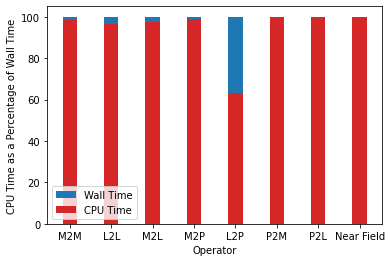

In [426]:
labels = ['M2M', 'L2L', 'M2L', 'M2P', 'L2P', 'P2M', 'P2L', 'Near Field']

men_means = [20, 35, 30, 35, 27]

women_means = [25, 32, 34, 20, 25]

men_std = [2, 3, 4, 1, 2]


women_std = [3, 5, 2, 3, 3]

width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()



ax.bar(labels, np.ones(8)*100, width, bottom=0,
       label='Wall Time', color='tab:blue')

ax.bar(
    labels,
    fractions*100,
    width, 
#     y/err=wall_times['std'].values(), 
    label='CPU Time',
    color='tab:red'
)

ax.set_ylabel('CPU Time as a Percentage of Wall Time')
ax.set_xlabel('Operator')
ax.legend(loc=3)

# plt.show()

plt.savefig('cpu_wall.png', dpi=500)

In [427]:
u_size = []
for u in e.u_lists:
    u_size.append(len(u[u != -1]))
u_size = np.array(u_size)


v_size = []
for v in e.v_lists:
    v_size.append(len(v[v != -1]))
v_size = np.array(v_size)


x_size = []
for x in e.x_lists:
    x_size.append(len(x[x != -1]))
x_size = np.array(x_size)


w_size = []
for w in e.w_lists:
    w_size.append(len(w[w != -1]))
w_size = np.array(w_size)

In [428]:
u_size.mean()

10.670155128501968

In [429]:
v_size.mean()

41.51113683723084

In [430]:
x_size.mean()

2.317851354480204

In [431]:
w_size.mean()

2.317851354480204